In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt 
from IPython import display
import glob
import math

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## 1.1 Get file paths for MRI T1 contrast images

In [2]:
local_directory = '../data/' 

In [3]:
def get_mha_filepaths(image_type, directory_path):
    return [_ for _ in glob.glob(directory_path) if _.split('/')[-1].split('.')[-3] == image_type]

In [4]:
image_types = ['MR_Flair', 'MR_T1', 'MR_T1c', 'MR_T2', 'OT']
directory_LGG = local_directory + 'train/LGG/*/*'
directory_HGG = local_directory + 'train/HGG/*/*'
t1c_paths_LGG = get_mha_filepaths(image_types[0], directory_LGG)
t1c_paths_HGG = get_mha_filepaths(image_types[0], directory_HGG)

## 1.2 Scale and normalize data

In [8]:
def scale_and_normalize(arr):
    arr = arr.astype('float32')
    mean, stand_dev = arr.mean(), arr.std()
    arr = (arr-mean)/stand_dev
    arr = np.clip(arr, -1, 1)
    arr = (arr+1)/2
    return arr

## 1.3 Get image arrays

In [9]:
def get_slice_from_filepath(mha_filepath, slice_index):
    volume = sitk.ReadImage(mha_filepath)
    volume_arr = sitk.GetArrayFromImage(volume)
    img_arr = np.array([volume_arr[0], volume_arr[slice_index], volume_arr[-1]])
    return scale_and_normalize(img_arr)

In [10]:
slice_index = int(155/2)

t1c_mri_LGG = np.array([get_slice_from_filepath(filepath, slice_index) for filepath in t1c_paths_LGG])
t1c_mri_HGG = np.array([get_slice_from_filepath(filepath, slice_index) for filepath in t1c_paths_HGG])

labels_LGG = np.array([0 for _ in range(len(t1c_mri_LGG))])
labels_HGG = np.array([1 for _ in range(len(t1c_mri_HGG))])

In [11]:
data = np.concatenate((t1c_mri_LGG, t1c_mri_HGG), axis=0)
labels = np.concatenate((labels_LGG, labels_HGG), axis=0)

## 2.1 Split into train and test sets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = .33, shuffle=True, stratify=labels)

NameError: name 'x_train' is not defined

<Figure size 432x288 with 0 Axes>

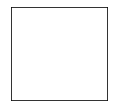

In [7]:
plt.set_cmap('gray')
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel('LGG' if y_train[i] == 0 else 'HGG')
plt.show()

In [13]:
x_train.shape

(183, 3, 240, 240)

## 2.2 Reshape to have one channel

In [31]:
x_train_3d = x_train.reshape(-1, 240, 240, 3, 1)
x_test_3d = x_test.reshape(-1, 240, 240, 3, 1)

In [15]:
%load_ext tensorboard

In [36]:
model = keras.models.Sequential([
    keras.layers.Conv3D(32, 3, strides = (2, 2, 1), activation='relu', input_shape=(240, 240, 3, 1), data_format='channels_last', name = 'conv0'),
    keras.layers.MaxPool3D((2, 2, 1), name='max_pool0'),
    keras.layers.BatchNormalization(name = 'bn0'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation = 'sigmoid')])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv3D)               (None, 119, 119, 1, 32)   896       
_________________________________________________________________
max_pool0 (MaxPooling3D)     (None, 59, 59, 1, 32)     0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 59, 59, 1, 32)     128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 111392)            0         
_________________________________________________________________
dropout (Dropout)            (None, 111392)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 111393    
Total params: 112,417
Trainable params: 112,353
Non-trainable params: 64
_______________________________________________

In [38]:
from sklearn.utils import compute_class_weight
classes = [0,1]
classWeight = compute_class_weight('balanced', classes, y_train) 
classWeight = dict(enumerate(classWeight))

In [39]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss = 'binary_crossentropy',
             optimizer = opt, metrics = ['binary_accuracy'])

In [40]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

neural_net = model.fit(x_train_3d, y_train, batch_size=32, epochs = 10, validation_data = (x_test_channels, y_test), class_weight=classWeight, callbacks=[tensorboard_callback])

Epoch 1/10
6/6 [==============================] - 16s 3s/step - loss: 1.0535 - binary_accuracy: 0.2457 - val_loss: 0.6818 - val_binary_accuracy: 0.8022
Epoch 2/10
6/6 [==============================] - 14s 2s/step - loss: 0.7935 - binary_accuracy: 0.5342 - val_loss: 0.6960 - val_binary_accuracy: 0.4066
Epoch 3/10
6/6 [==============================] - 12s 2s/step - loss: 0.9393 - binary_accuracy: 0.6101 - val_loss: 0.6888 - val_binary_accuracy: 0.6813
Epoch 4/10
6/6 [==============================] - 12s 2s/step - loss: 0.8078 - binary_accuracy: 0.6156 - val_loss: 0.6793 - val_binary_accuracy: 0.8022
Epoch 5/10
6/6 [==============================] - 12s 2s/step - loss: 0.7424 - binary_accuracy: 0.5136 - val_loss: 0.6755 - val_binary_accuracy: 0.8022
Epoch 6/10
6/6 [==============================] - 12s 2s/step - loss: 0.7667 - binary_accuracy: 0.4657 - val_loss: 0.6754 - val_binary_accuracy: 0.8022
Epoch 7/10
6/6 [==============================] - 13s 2s/step - loss: 0.7040 - binary_ac

In [116]:
# %reload_ext tensorboard
%tensorboard --logdir {logdir}  --host localhost

In [24]:
sum(y_test)/len(y_test)

0.8021978021978022

In [41]:
model.predict_classes(x_test_3d)

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [ ]:
# augment the smaller class?
# train 3 separately and take majority?